In [1]:
import pandas as pd
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
import matplotlib.pyplot as plt


In [2]:
pd.set_option('display.max_rows', 500)


In [3]:
num_input = 115

model = Sequential()
model.add(Dense(1024, input_shape=(num_input,), activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='leaky_relu'))
model.add(Dropout(0.3))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.load_weights('../predictor/saved_models/only_in_game_data_v3.keras')


In [4]:
BASE_URL = 'https://feed.lolesports.com/livestats/v1/window/{}?startingTime={}'

In [5]:
champ_df = pd.read_csv('../../post_champ_selection/data/gameData1451/champs.csv')
champ_df['champ_index'] = champ_df.index
champ_df = champ_df[['name','champ_index']]

In [6]:
def extract_fixed_info(json_data):
    ret_data = dict()
    # ret_data['patch_version'] = json_data['gameMetadata']['patchVersion']
    # ret_data['blue_team_id'] = json_data['gameMetadata']['blueTeamMetadata']['esportsTeamId']
    for i,pos in enumerate(['top','jungle','mid','bot','supp']):

        # ret_data[F'blue_{pos}_player'] = json_data['gameMetadata']['blueTeamMetadata']['participantMetadata'][i]['esportsPlayerId']
        ret_data[F'blue_{pos}_champ'] = json_data['gameMetadata']['blueTeamMetadata']['participantMetadata'][i]['championId']

    # ret_data['red_team_id'] = json_data['gameMetadata']['redTeamMetadata']['esportsTeamId']
    for i,pos in enumerate(['top','jungle','mid','bot','supp']):

        # ret_data[F'red_{pos}_player'] = json_data['gameMetadata']['redTeamMetadata']['participantMetadata'][i]['esportsPlayerId']
        ret_data[F'red_{pos}_champ'] = json_data['gameMetadata']['redTeamMetadata']['participantMetadata'][i]['championId']

    return ret_data

def encode_dragons(team,info):
    ret_data = dict()
    for drake in ['ocean_drakes','cloud_drakes','mountain_drakes','chemtech_drakes','infernal_drakes','hextech_drakes','elder_drakes']:
        ret_data[F"{team}_{drake}"] = 0
    for d in info:
        k = F"{team}_{d}_drakes"
        ret_data[k] = ret_data[k] + 1
    
    return ret_data

def extract_changing_info(json_data):
    ret_data = dict()
    # ret_data['rfc460Timestamp'] = json_data['rfc460Timestamp']
    for clr in ['blue','red']:
        ret_data[F'{clr}_team_total_gold'] = json_data[F'{clr}Team']['totalGold']
        ret_data[F'{clr}_team_inhibitors'] = json_data[F'{clr}Team']['inhibitors']
        ret_data[F'{clr}_team_towers'] = json_data[F'{clr}Team']['towers']
        ret_data[F'{clr}_team_barons'] = json_data[F'{clr}Team']['barons']
        ret_data[F'{clr}_team_total_kills'] = json_data[F'{clr}Team']['totalKills']
        ret_data.update(encode_dragons(F'{clr}_team',json_data[F'{clr}Team']['dragons']))

        for i,pos in enumerate(['top','jungle','mid','bot','supp']):
            ret_data[F'{clr}_{pos}_total_gold'] = json_data[F'{clr}Team']['participants'][i]['totalGold']
            ret_data[F'{clr}_{pos}_level'] = json_data[F'{clr}Team']['participants'][i]['level']
            ret_data[F'{clr}_{pos}_kills'] = json_data[F'{clr}Team']['participants'][i]['kills']
            ret_data[F'{clr}_{pos}_deaths'] = json_data[F'{clr}Team']['participants'][i]['deaths']
            ret_data[F'{clr}_{pos}_assists'] = json_data[F'{clr}Team']['participants'][i]['assists']
            ret_data[F'{clr}_{pos}_creep_score'] = json_data[F'{clr}Team']['participants'][i]['creepScore']
            ret_data[F'{clr}_{pos}_current_health'] = json_data[F'{clr}Team']['participants'][i]['currentHealth']
            ret_data[F'{clr}_{pos}_max_health'] = json_data[F'{clr}Team']['participants'][i]['maxHealth']


    return ret_data

def format_time(t,time_delta):
    conv_time = pd.to_datetime(t) + pd.to_timedelta(time_delta, unit='s')
    conv_time = conv_time.round('10s')
    return "{}T{}.000Z".format(str(conv_time.date()),str(conv_time.time()))


In [7]:
def get_unix_time(value):
    try:
        return (pd.to_datetime(value,format='%Y-%m-%dT%H:%M:%S.%fZ')- pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    except ValueError:
        return (pd.to_datetime(value,format='%Y-%m-%dT%H:%M:%SZ')- pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
def get_champ_index(df):
    for clr in ['blue','red']:
        for i,pos in enumerate(['top','jungle','mid','bot','supp']):
            col = F"{clr}_{pos}_champ"

            df[col] = df[col].apply(lambda x: champ_df[champ_df['name'] == x].champ_index.index[0])

In [8]:
def make_prediction(df):
    result = model.predict(df)
    return result

In [9]:
match_id = 112352881166864387

2 hours behind on the time here: https://lol.fandom.com/wiki/LEC/2024_Season/Summer_Season/Scoreboards

In [10]:
min_start_time = pd.Timestamp('2024-06-08 16:10:00+00:00')
# unix_start_time =  get_unix_time('2024-04-14T15:00:00Z')

In [23]:
time_delta = 60
temp_list = []

predictions = []

game_state = "in_game"
fixed_info = None
time_elapsed = 0
game_start_time = -1

while game_state == "in_game" or game_state == "paused":

    url = BASE_URL.format(match_id,format_time(min_start_time,time_elapsed))
    raw_data = requests.get(url)

    time_elapsed = time_elapsed + time_delta
    if raw_data.status_code == 204: # No content returned
        continue

    data = raw_data.json()
    if fixed_info == None:
        fixed_info = extract_fixed_info(data)
    

    prev_frame = data['frames'][0]
    for frame in data['frames'][1:]:

        delta_info = extract_changing_info(frame)
        if delta_info == prev_frame:
            continue

        delta_info.update(fixed_info)
        if game_start_time == -1:
            game_start_time = get_unix_time(frame['rfc460Timestamp'])
        delta_info['time_in_game'] = get_unix_time(frame['rfc460Timestamp'])-game_start_time

        # delta_info['rfc460Timestamp'] = frame['rfc460Timestamp']
        # delta_info.update(row)
        df = pd.DataFrame(delta_info,index=[0])
        get_champ_index(df)

        prediction = make_prediction(df)
        if 'time_in_game' in prev_frame.keys() and prev_frame['time_in_game'] != delta_info['time_in_game'] and game_state == 'in_game':
            print(F"Prediction at {delta_info['time_in_game']}s")
            print(prediction[0][0])
            print("\n\n")
            predictions.append(prediction[0][0])
        # temp_list.append(delta_info)
        prev_frame = delta_info

    game_state = data['frames'][-1]['gameState']


1/1 [==============================] - 0s 15ms/step
Prediction at 1s
0.4683467



1/1 [==============================] - 0s 14ms/step
Prediction at 2s
0.46828812



1/1 [==============================] - 0s 20ms/step
Prediction at 3s
0.46826857



1/1 [==============================] - 0s 46ms/step
Prediction at 4s
0.46824053



1/1 [==============================] - 0s 14ms/step
Prediction at 5s
0.468145



1/1 [==============================] - 0s 26ms/step
Prediction at 6s
0.46815723



1/1 [==============================] - 0s 16ms/step
Prediction at 7s
0.46808398



1/1 [==============================] - 0s 21ms/step
Prediction at 8s
0.46808466



1/1 [==============================] - 0s 11ms/step
Prediction at 61s
0.46008888



1/1 [==============================] - 0s 19ms/step
Prediction at 62s
0.46011597



1/1 [==============================] - 0s 17ms/step
Prediction at 63s
0.46003452



1/1 [==============================] - 0s 10ms/step
Prediction at 64s
0.46012375



1/1

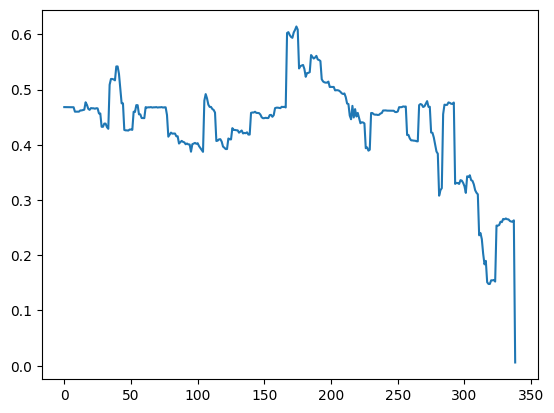

In [26]:
plt.plot([x for x in range(len(predictions))],predictions)

In [27]:
predictions

[0.4683467,
 0.46828812,
 0.46826857,
 0.46824053,
 0.468145,
 0.46815723,
 0.46808398,
 0.46808466,
 0.46008888,
 0.46011597,
 0.46003452,
 0.46012375,
 0.46231043,
 0.46233773,
 0.46308056,
 0.46370453,
 0.47708932,
 0.4723534,
 0.46520144,
 0.46337262,
 0.46653265,
 0.46621385,
 0.46615782,
 0.46543738,
 0.4662915,
 0.46604902,
 0.4568435,
 0.45686013,
 0.43270466,
 0.43265057,
 0.43849957,
 0.43844035,
 0.43203276,
 0.4290468,
 0.50883394,
 0.51930666,
 0.5193116,
 0.51849735,
 0.5168076,
 0.5420045,
 0.54201394,
 0.52860093,
 0.502597,
 0.4751759,
 0.4751515,
 0.4269833,
 0.42621964,
 0.4262006,
 0.42583194,
 0.42776594,
 0.4277684,
 0.42711845,
 0.45999396,
 0.45947286,
 0.47191095,
 0.47182858,
 0.4552697,
 0.45521504,
 0.4485726,
 0.44836769,
 0.4483539,
 0.46833226,
 0.46754643,
 0.46797615,
 0.46795446,
 0.46833226,
 0.46754643,
 0.46797615,
 0.46795446,
 0.46833226,
 0.46754643,
 0.46797615,
 0.46795446,
 0.46833226,
 0.46754643,
 0.46797615,
 0.46795446,
 0.45397884,
 0.414